# Static maps  with matplotlib

- https://kodu.ut.ee/~kmoch/geopython2020/L6/static-maps.html

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

# Filepaths
grid_fp = "population_square_km.shp"

roads_fp = "roads.shp"

schools_fp = "schools_tartu.shp"

# Read files
grid = gpd.read_file(grid_fp)

roads = gpd.read_file(roads_fp)

schools = gpd.read_file(schools_fp)

In [2]:
gridCRS = grid.crs
roads['geometry'] = roads['geometry'].to_crs(crs=gridCRS)
schools['geometry'] = schools['geometry'].to_crs(crs=gridCRS)

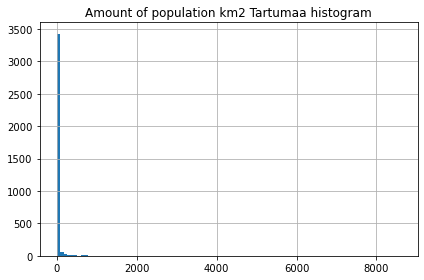

In [3]:
# Plot
grid.hist(column="Population", bins=100)
# Add title
plt.title("Amount of population km2 Tartumaa histogram")
plt.tight_layout()

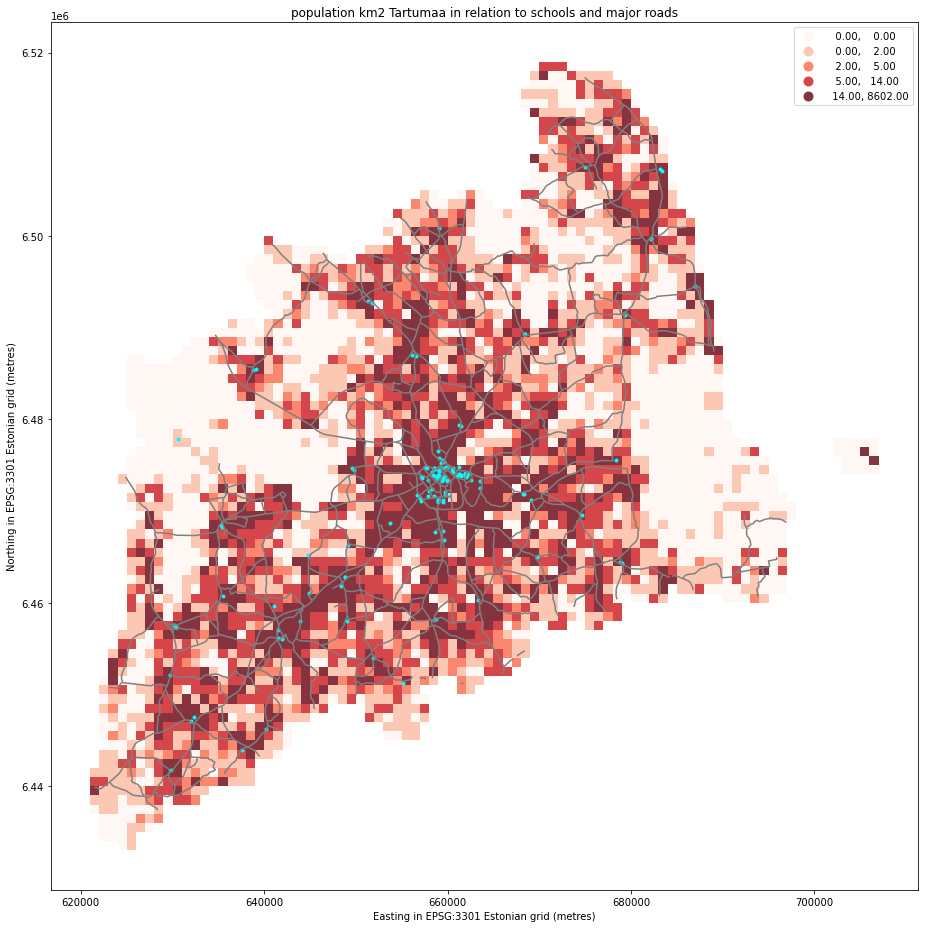

In [4]:
fig, ax = plt.subplots(figsize=(15, 13))

# Visualize the population density into 5 classes using "Quantiles" classification scheme
# Add also a little bit of transparency with `alpha` parameter
# (ranges from 0 to 1 where 0 is fully transparent and 1 has no transparency)
grid.plot(column="Population", ax=ax, linewidth=0.03, cmap="Reds", scheme="quantiles", k=5, alpha=0.8, legend=True)

# Add roads on top of the grid
# (use ax parameter to define the map on top of which the second items are plotted)
roads.plot(ax=ax, color="grey", linewidth=1.5)

# Add schools on top of the previous map
schools.plot(ax=ax, color="cyan", markersize=9.0)

# Remove the empty white-space around the axes
plt.title("population km2 Tartumaa in relation to schools and major roads")

ax.set_ylabel('Northing in EPSG:3301 Estonian grid (metres)')
ax.set_xlabel('Easting in EPSG:3301 Estonian grid (metres)')

plt.tight_layout()

In [5]:
outfp = "static_map.png"
plt.savefig(outfp, dpi=300)

<Figure size 432x288 with 0 Axes>

### EarthPy DEM and Hillshade raster with normal GeoDataFrame vector data

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import rasterio as rio

dtm = '../L5/dem.tif'

# Open the DEM with Rasterio
src = rio.open(dtm)
elevation = src.read(1)

In [7]:
import geopandas as gpd

catchments = gpd.read_file('../L5/porijogi_sub_catchments.geojson')

subcatch = catchments.loc[catchments['NAME_1']=='Idaoja']

# protected species under class 3 monitoring sightings
species_fp = "../L3/category_3_species_porijogi.gpkg"

species_data = gpd.read_file(species_fp, layer='category_3_species_porijogi', driver='GPKG')

c:\dev\conda3\envs\geopy2021a\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [8]:
pip_mask = species_data.within(subcatch.loc[0, 'geometry'])
pip_data = species_data.loc[pip_mask]

In [9]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import collections

patchList = []

data_key = mpatches.Patch(color="gold", label="Selected Idaoja species")

patchList.append(data_key)
    

In [10]:
hillshade = es.hillshade(elevation)

In [11]:
# to define the bounds of the map (important for the raster layers plot)
extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

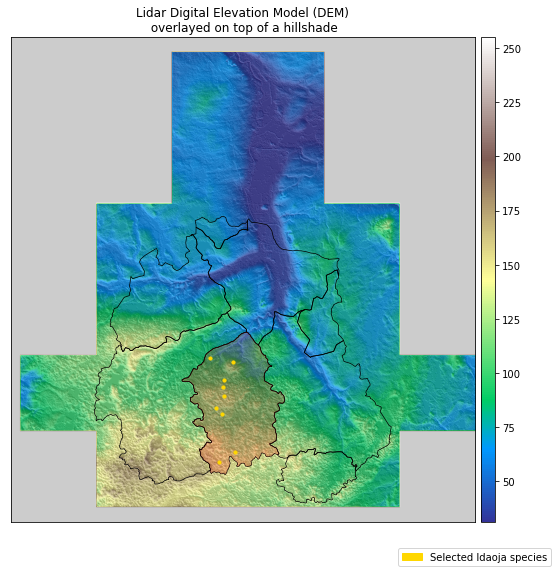

In [12]:
fig, ax = plt.subplots(figsize=(12,8))

ep.plot_bands(elevation, ax=ax, cmap="terrain", extent=extent, title="Lidar Digital Elevation Model (DEM)\n overlayed on top of a hillshade" )

ep.plot_bands(hillshade, cmap='Greys', extent=extent, ax=ax, alpha=0.3, cbar=None)

catchments.plot(ax=ax, facecolor="none", edgecolor='black', lw=0.7)

subcatch.plot(ax=ax, facecolor='red', alpha=0.2)

pip_data.plot(ax=ax, color='gold', markersize=10, legend=True)

plt.legend(handles=patchList, loc='lower center', bbox_to_anchor=(-0.5, -0.1), ncol=1)

plt.tight_layout()

plt.savefig('DEM_hillshade_etc.png')

### Special plots types with GeoPlot

### Using web tile layer as background and use mapclassify directly

https://residentmario.github.io/geoplot/gallery/index.html

https://contextily.readthedocs.io/en/latest/

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

fp = "../L4/population_admin_units.shp"

acc = gpd.read_file(fp)
acc['pop_int'] = acc['population'].apply(pd.to_numeric, errors='coerce').dropna()
acc_wgs84 = acc.to_crs(4326)


In [14]:
import geoplot as gplt
import geoplot.crs as gcrs

In [15]:
import mapclassify as mc

In [16]:
import contextily as ctx

Text(0.5, 1.0, 'Population per municipality')

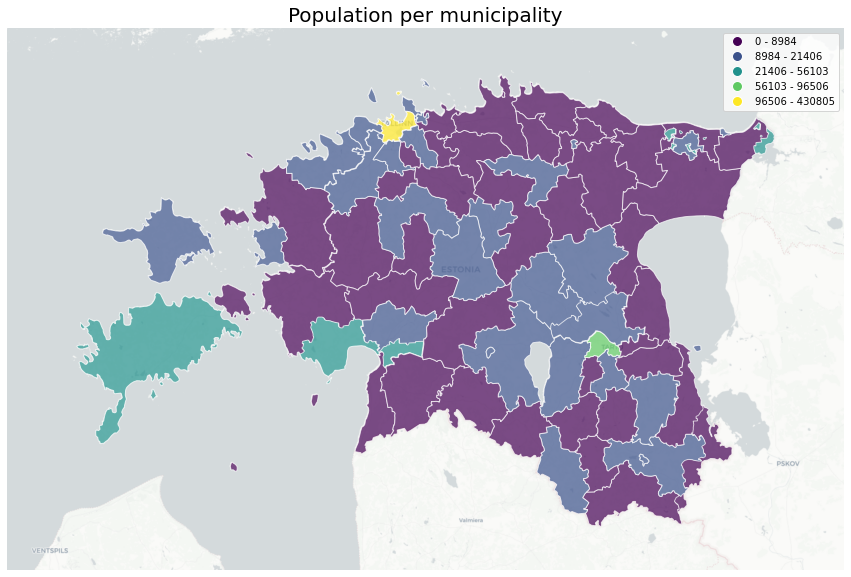

In [17]:
ax = gplt.webmap(df=acc_wgs84, projection=gcrs.WebMercator(), zoom=8, provider=ctx.providers.CartoDB.Positron, figsize=(15,12))

scheme = mc.FisherJenks(acc_wgs84[['pop_int']], k=5)
    
gplt.choropleth(
    acc_wgs84, hue='pop_int', projection=gcrs.WebMercator(),
    edgecolor='white', linewidth=1, alpha=0.7, 
    cmap='viridis', legend=True,
    ax=ax,
    scheme=scheme
)

plt.title("Population per municipality", fontsize=20)

### GeoPlot cartogram, using a variable as scale for size of polygon

https://residentmario.github.io/geoplot/api_reference.html

Text(0.5, 1.0, 'Population per municipality as cartogram')

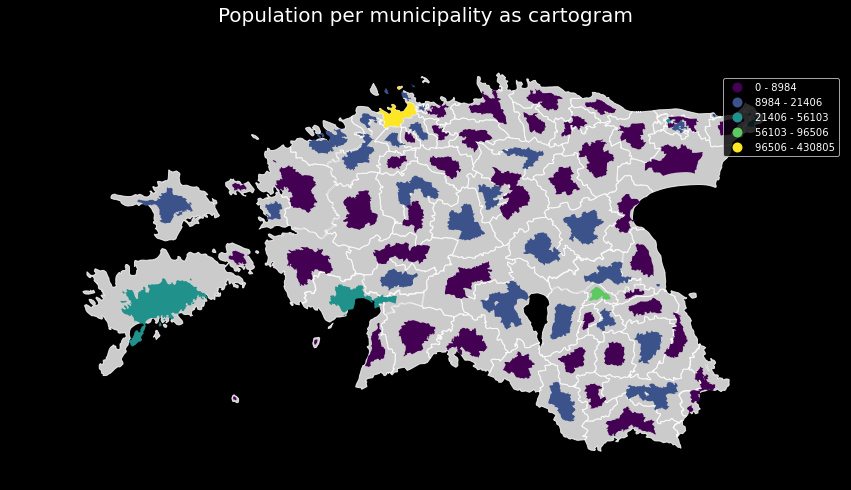

In [18]:
plt.style.use('dark_background')

ax = gplt.cartogram(
    acc_wgs84, scale='pop_int', projection=gcrs.AlbersEqualArea(),
    legend=True, legend_kwargs={'bbox_to_anchor': (1, 0.9)}, legend_var='hue',
    hue='pop_int',
    scheme=scheme,
    cmap='viridis',
    limits=(0.5, 1),
    figsize=(15,12)
)
gplt.polyplot(acc_wgs84, facecolor='white', edgecolor='white', alpha=0.8, ax=ax)

plt.title("Population per municipality as cartogram", fontsize=20)

### GeoPlot making a static KDE plot as contour or filled

https://residentmario.github.io/geoplot/api_reference.html

In [19]:
plt.style.use('default')

In [20]:
c4 = catchments.to_crs(4326)
s4 = species_data.to_crs(4326)

In [21]:
fig = plt.figure()

proj = gcrs.WebMercator()

ax = gplt.webmap(df=gpd.overlay(c4, s4, how='union'), projection=proj, zoom=10, provider=ctx.providers.Stamen.Toner, figsize=(15,12))

ax = gplt.pointplot(s4, projection=proj, color='green', edgecolor='white',  linewidth=0.5, alpha=0.8, ax=ax)

ax = gplt.kdeplot(s4, projection=proj, cmap='YlOrRd', shade=False, linewidths=5, alpha=0.7, ax=ax)

ax.set_title("Distribution of recorded specimen in south Tartu county", fontsize=18)

plt.savefig("species-kde.png", bbox_inches='tight')

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

<Figure size 640x480 with 0 Axes>

In [ ]:
proj = gcrs.AlbersEqualArea()

ax = gplt.pointplot(s4, projection=proj, color='green', edgecolor='white',  linewidth=0.5, alpha=0.8, figsize=(15,12))

ax = gplt.polyplot(c4, projection=proj, edgecolor='black',  linewidth=2, alpha=0.7, ax=ax)

ax = gplt.kdeplot(s4, projection=proj, cmap='YlOrRd', shade=True, alpha=0.7, ax=ax)